<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [81]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from bs4 import BeautifulSoup
import squarify
from sklearn.neighbors import NearestNeighbors

nlp = spacy.load("en_core_web_lg")

## 1) *Optional:* Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

If you choose to not to scrape the data, there is a CSV with outdated data in the directory. Remeber, if you scrape Indeed, you're helping yourself find a job. ;)

In [2]:
jobs = pd.read_csv("/Users/ianforrest/Desktop/coding/repos/ianforrest11/DS-Unit-4-Sprint-1-NLP/module2-vector-representations/data/job_listings.csv", index_col=0)
jobs.head()

,description,title
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


In [3]:
jobs.shape

(426, 2)

In [74]:
x = jobs['description'][0]

In [5]:
nlp.Defaults.stop_words |= {"it's", "i", "the", "and", "to",
                            "i'm", "i've", "it"}


In [6]:
nlp.vocab.add_flag(lambda s: s.lower() in spacy.lang.en.stop_words.STOP_WORDS, spacy.attrs.IS_STOP)

12

In [73]:
from html.parser import HTMLParser

class HTMLStripper(HTMLParser):
    def __init__(self):
        self.data = []
        super().__init__()
    
    def handle_data(self, data):
        if self.data:
            self.data.append(data)
        else:
            self.data = [data]

def strip_desc(text):
    temp = text[2:(len(text)-1)]
    parser = HTMLStripper()
    parser.feed(temp)
    return parser.data

In [75]:
strip_desc(x)

['Job Requirements:',
 '\\nConceptual understanding in Machine Learning models like Nai\\xc2\\xa8ve Bayes, K-Means, SVM, Apriori, Linear/ Logistic Regression, Neural, Random Forests, Decision Trees, K-NN along with hands-on experience in at least 2 of them',
 '\\n',
 'Intermediate to expert level coding skills in Python/R. (Ability to write functions, clean and efficient data manipulation are mandatory for this role)',
 '\\n',
 'Exposure to packages like NumPy, SciPy, Pandas, Matplotlib etc in Python or GGPlot2, dplyr, tidyR in R',
 '\\n',
 'Ability to communicate Model findings to both Technical and Non-Technical stake holders',
 '\\n',
 'Hands on experience in SQL/Hive or similar programming language',
 '\\n',
 'Must show past work via GitHub, Kaggle or any other published article',
 '\\n',
 "Master's degree in Statistics/Mathematics/Computer Science or any other quant specific field.",
 '\\nApply Now']

# use spacy to clean listings


In [78]:
# remove html code
from bs4 import BeautifulSoup

def remove_html(df):
    df = df.copy()
    df['description'] = df['description'].str.replace('\n', '')
    df['description'] = df['description'].str.replace('\n\n ', '')   
    df['description'] = df['description'].str.replace(":\n", '')
    df['description'] = df['description'].str.replace('b"', '')
    df['description'] = df['description'].str.replace("b'", '')
    df['description'] = df['description'].str.replace("Job Description", '')
    df['description'] = df['description'].str.replace("Job Requirements", '')
    df = df.applymap(lambda text: BeautifulSoup(text, 'html.parser').get_text())

    
    return df


In [79]:
df = remove_html(jobs)
df.head()

,description,title
0,:\nConceptual understanding in Machine Learnin...,Data scientist
1,"\n\nAs a Data Scientist 1, you will help us bu...",Data Scientist I
2,As a Data Scientist you will be working on con...,Data Scientist - Entry Level
3,"$4,969 - $6,756 a monthContractUnder the gener...",Data Scientist
4,Location: USA \xe2\x80\x93 multiple locations\...,Data Scientist


In [9]:
df['description'][0]

':\\nConceptual understanding in Machine Learning models like Nai\\xc2\\xa8ve Bayes, K-Means, SVM, Apriori, Linear/ Logistic Regression, Neural, Random Forests, Decision Trees, K-NN along with hands-on experience in at least 2 of them\\nIntermediate to expert level coding skills in Python/R. (Ability to write functions, clean and efficient data manipulation are mandatory for this role)\\nExposure to packages like NumPy, SciPy, Pandas, Matplotlib etc in Python or GGPlot2, dplyr, tidyR in R\\nAbility to communicate Model findings to both Technical and Non-Technical stake holders\\nHands on experience in SQL/Hive or similar programming language\\nMust show past work via GitHub, Kaggle or any other published article\\nMaster\'s degree in Statistics/Mathematics/Computer Science or any other quant specific field.\\nApply Now"'

In [10]:
from spacy.tokenizer import Tokenizer

# Tokenizer Pipe with removal of default stop words and coffee-specific stop words

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

tokens = []

""" Update those tokens w/o stopwords"""
for doc in tokenizer.pipe(df['description'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

df['tokens'] = tokens

In [20]:
from collections import Counter

# import 'count' function from lecture
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [11]:
df.head()

,description,title,tokens
0,:\nConceptual understanding in Machine Learnin...,Data scientist,"[:\nconceptual, understanding, machine, learni..."
1,"\n\nAs a Data Scientist 1, you will help us bu...",Data Scientist I,"[\n\nas, data, scientist, 1,, help, build, mac..."
2,As a Data Scientist you will be working on con...,Data Scientist - Entry Level,"[data, scientist, working, consulting, busines..."
3,"$4,969 - $6,756 a monthContractUnder the gener...",Data Scientist,"[$4,969, $6,756, monthcontractunder, general, ..."
4,Location: USA \xe2\x80\x93 multiple locations\...,Data Scientist,"[location:, usa, \xe2\x80\x93, multiple, locat..."


In [21]:
wc = count(df['tokens'])
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
50,data,420,3762,1.0,0.030077,0.030077,0.985915
76,business,303,1009,2.0,0.008067,0.038144,0.711268
24,experience,357,942,3.0,0.007531,0.045675,0.838028
51,work,326,876,4.0,0.007004,0.052679,0.765258
88,team,314,726,5.0,0.005804,0.058483,0.737089


In [27]:
df['tokens'].dtype

dtype('O')

## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [88]:
##### Your Code Here #####
count_vect = CountVectorizer()

dtm = count_vect.fit_transform(df.description.values)
dtm_df = pd.DataFrame(dtm.todense(),columns=count_vect.get_feature_names())

In [89]:
dtm_df.head()

,00,000,02115,03,0356,04,062,06366,08,10,...,zenreach,zero,zeus,zf,zheng,zillow,zones,zoom,zuckerberg,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
# remove common word columns
dtm_df = dtm_df.drop(columns=['from', 'this', 'x99s', 'all', 
                              'such', 'with', 'at', 'other', 
                              'have', 'as', 'you', 'on', 'as','in',
                              'or', 'are','by', 'for','and', 'to', 
                              'the', 'xe2', 'that', 'x80', 'we', 'of', 
                              'is', 'be', 'our', 'an', 'it', 'into', 
                              'nyou', 'your', '00', '000', '02115', '03',
                              '0356', '04', '062', '06366'])

## 4) Visualize the most common word counts

In [91]:
word_ranks = dtm_df.sum().sort_values(ascending=False)
word_ranks.head()

data          4394
will          1315
experience    1238
business      1198
work           976
dtype: int64

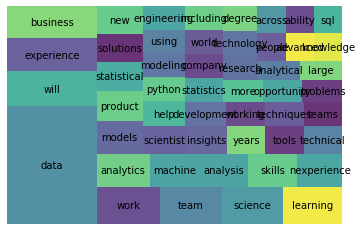

In [92]:
squarify.plot(sizes=word_ranks.values[:50], label=word_ranks.index[:50], alpha=0.8)
plt.axis('off')
plt.show();

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [93]:
# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words = 'english')

dtm_tfidf = tfidf.fit_transform(df.description.values)
dtm_tfidf_df = pd.DataFrame(dtm_tfidf.todense(),columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm_tfidf_df.head()

,00,000,02115,03,0356,04,062,06366,08,10,...,zenreach,zero,zeus,zf,zheng,zillow,zones,zoom,zuckerberg,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.104423,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [82]:
nn  = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
nn.fit(dtm_tfidf_df)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [85]:
dtm_tfidf_df.iloc[5].head()

00       0.0
000      0.0
02115    0.0
03       0.0
0356     0.0
Name: 5, dtype: float64

In [87]:

# Query Using kneighbors 
nn.kneighbors([dtm_tfidf_df.iloc[5]])

(array([[0.        , 1.25838832, 1.25838832, 1.27393399, 1.27436695]]),
 array([[  5, 119, 177, 327, 280]]))

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 